# The Variational Quantum Linear Solver

#### Editor's note:

Consulted Pennylane tutorial on VQLS, found [here](https://pennylane.ai/qml/demos/tutorial_vqls).

Qiskit version: `2.0.0`

In [1]:
%pip install --upgrade -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.


### Importing libraries

In [7]:
from IPython.display import display

import qiskit as qk
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.circuit.library import UGate
from qiskit.exceptions import QiskitError
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, EstimatorOptions
from qiskit_ibm_runtime.fake_provider import FakeFez
from qiskit.quantum_info import Statevector, Operator, PauliList, Operator, SparsePauliOp, Pauli
from qiskit.transpiler.passes import RemoveBarriers
from qiskit.visualization import array_to_latex, plot_histogram

import math
import random
import numpy as np
from numpy import pi
from numpy import array, sqrt

from scipy.optimize import minimize
import matplotlib.pyplot as plt

import tqdm

# For simulation
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimatorV2

print(f"Qiskit version: {qk.__version__}")

Qiskit version: 2.2.1


## 1. Introduction

The Variational Quantum Linear Solver (VQLS) is a kind of variational quantum algorithm (VQA) that solves systems of linear equations. 

Given a matrix $A$, such that $Ax = b$, where $b$ is some known vector, the VQLS algorithm finds a normalized $|x\rangle$ proportional to $x$ that satisfies $Ax=b$.



## 2. The Algorithm

First, we prepare a candidate solution, $|x(\alpha)\rangle$ conditioned on a set of parameters $\alpha$, using a quantum circuit $V(\alpha)$. This quantum circuit is called the `ansatz`.

From the ansatz, we obtain $|x(\alpha)\rangle = V(\alpha) |0\rangle$. 

Next, we prepare $|b\rangle = U|0\rangle$ for some unitary matrix $U$. Hence, $|b\rangle$ is a unitary vector proportional to the vector $b$ in $Ax=b$. To do this, we need to construct a quantum circuit representation of $U$.

Second, we design a quantum circuit to compute a cost value, $C(\alpha)$, conditioned on parameters $\alpha$, which were used to prepare $|x(\alpha)\rangle$. The cost should represent the difference between our candidate solution and the real solution.

Next, we iteratively improve our ansatz parameters, $\alpha$, by minimizing $C(\alpha)$ using classical optimization methods.

We repeat this process until $C(\alpha)$ stablizes, at which point we use parameters $\alpha$ to recover our final solution, $|x(\alpha)\rangle$.

![alt text](images/bro.png)

### Cost Function

Several cost functions for evaluating $C(\alpha)$ are proposed:

#### Global cost function, $C_G$

Since $\alpha$ is fixed at each evaluation step, we write $|x\rangle$ in place of $|x(\alpha)\rangle$. 

Notice that $|b\rangle$ and $|x\rangle$ are always unitary, but the same cannot be said for $A|x\rangle$. This is because $A$ is only assumed to be Hermitian, not necessarily unitary. The inner product of $|b\rangle$ and $A|x\rangle$ is a complex scalar. Thus, we multiply it by its own conjugate to obtain its norm-squared, which is a scalar between 0 and 1. The "closer"  $A|x\rangle$ is to $|b\rangle$, the bigger their inner product, the smaller the global cost.

$$C_G = 1 - \| \langle b| \frac{A|x\rangle}{\|A|x\rangle\|} \rangle \|^2$$

$$ = 1 - \| \frac{\langle 0| U^{\dagger} A |x\rangle}{\sqrt{\langle x| A^\dagger A |x\rangle}} \|^2$$

$$= 1 - \frac{ \langle x| A^\dagger U | 0 \rangle \langle 0 | U^\dagger A | x \rangle }{\langle x | A^\dagger A | x \rangle}$$

As the number of qubits increases, the gradient of $C_G$ vanishes. We can replace $|0\rangle \langle 0|$ with another matrix to improve performance. This is because $|0\rangle \langle 0|$ only picks out the first entry, e.g., $|0000\rangle$, but we want to encourage every improvement towards having more $0$'s, e.g. from $|0110\rangle$ to $|0100\rangle$. 

<br>

#### Local cost function, $C_L$.

We replace $|0\rangle \langle 0|$ in $C_G$ with $P_0$.

First, let us define
$$P_0 = \frac{1}{2} + \frac{1}{2n} \sum_{j=1}^{n} Z_j$$
where $Z_j$ is the Pauli-Z operator on the j-th qubit and identity on every other qubit.

Also,
$$P_1 = \left( \mathbb{1} - \frac{1}{n} \sum_{j=1}^{n} |0_j \rangle \langle 0_{j} | \otimes \mathbb{1}_{\bar{j}} \right)$$
where $\mathbb{1}_{\bar{j}}$ is the identity on all qubits except the j-th qubit.

$P_0$ and $P_1$ are diagonal matrices. When multipled by a standard-basis vector, $P_0$ counts the number of $0$'s in the vector, and $P_1$ counts the number of $1$'s. For example, if $|a\rangle = |01100 \rangle$ is a standard basis vector having 3 $0$'s and 5 qubits, then $P_0 |a\rangle = \frac{3}{5} |a\rangle$, and $P_1 |a\rangle = \frac{2}{5} |a\rangle$.

Notice the relation

$$P_1 = \mathbb{I} - P_0 $$

Therefore,

$$C_L = \frac{\langle x | A^\dagger U P_1 U^\dagger A | x \rangle} {\langle x | A^\dagger A | x \rangle}$$

$$ = \frac{\langle x | A^\dagger U P_1 U^\dagger A | x \rangle} {\langle x | A^\dagger U \mathbb{1} U^\dagger A | x \rangle}$$

$$ = \frac{\langle x | A^\dagger U \mathbb{I} U^\dagger A | x \rangle - \langle x | A^\dagger U P_0 U^\dagger A | x \rangle} {\langle x | A^\dagger U \mathbb{I} U^\dagger A | x \rangle}$$

$$ = 1 - \frac{\langle x | A^\dagger U P_0 U^\dagger A | x \rangle} {\langle x | A^\dagger A | x \rangle}$$

$$ = \frac{1}{2} - \frac{1}{2n} \frac{\sum_{j=0}^{n-1}\langle x | A^\dagger U Z_j U^\dagger A | x \rangle} {\langle x | A^\dagger A | x \rangle}$$

$$ = \frac{1}{2} - \frac{1}{2n} \frac{\sum_{j=0}^{n-1}\langle 0|V^\dagger A^\dagger U Z_j U^\dagger A V|0 \rangle} {\langle 0|V^\dagger A^\dagger A  V|0 \rangle}$$


Since controlled-Z gate is native to IBM Heron processor, we can directly transpile Controlled-$Z_j$ gates to improve algorithm efficiency for IBM Heron processors.

Since

$$A = \sum_{l=1}^{L} c_lA_l$$
where $c_l \in \mathbb{C}$, we can expand $A$ to obtain

$$ C_L = \frac{1}{2} - \frac{1}{2n} \frac{\sum_{j=0}^{n-1} \sum_{l=1}^{L} \sum_{l'=1}^{L} c_lc_{l'}^*\langle 0|V^\dagger A_{l'}^\dagger U Z_j U^\dagger A_l V|0 \rangle} {\sum_{l=1}^{L} \sum_{l'=1}^{L} c_lc_{l'}^* \langle 0|V^\dagger A_{l'}^\dagger A_l  V|0 \rangle}$$


## 3. Building Quantum Circuit with Qiskit



### Consider an Example

Let us construct a 4x4 tridiagonal matrix, $A$. We generate a random vector $|x_0\rangle$ and obtain $|b\rangle$ from the equation $A |x_0\rangle =|b\rangle$. 

We apply VQLS, using $A$ and $|b\rangle$ as inputs, to solve for $|x\rangle$ in $A |x\rangle =|b\rangle$. We then compare our solution with the real solution $|x_0\rangle$.

In [3]:
A = np.array([[2,-1,0,0],
            [-1,2,-1,0],
            [0,-1,2,-1],
            [0,0,-1,2]])

print("Define the matrix, A, to be the following:")
display(array_to_latex(A))

Define the matrix, A, to be the following:


<IPython.core.display.Latex object>

### Decomposing A into LCU

We decompose $A$ into a Linear Combination of Pauli Strings (LCU). This is done by writing $A$ as a sum of Pauli operators, each multiplied by a coefficient.

In [4]:
# Apply SparsePauliOp()
LCU = SparsePauliOp.from_operator(A)
print(LCU, end="\n\n")

print("The Pauli strings are:")
print(LCU.paulis, end="\n\n")

print("The coefficients are:")
print(LCU.coeffs)

print(f"\nThe number of qubits is {LCU.num_qubits}.")

SparsePauliOp(['II', 'IX', 'XX', 'YY'],
              coeffs=[ 2. +0.j, -1. +0.j, -0.5+0.j, -0.5+0.j])

The Pauli strings are:
['II', 'IX', 'XX', 'YY']

The coefficients are:
[ 2. +0.j -1. +0.j -0.5+0.j -0.5+0.j]

The number of qubits is 2.


Hence, we have

$$
A = 2II - 1IX - 0.5XX - 0.5YY
$$

where $I$, $X$, $Y$ are Pauli matrices. 

### Define Controlled-A Circuits
For the Hadamard Test, let us define the function `CA()` that creates controlled circuits for each Pauli string in the LCU. 

IX


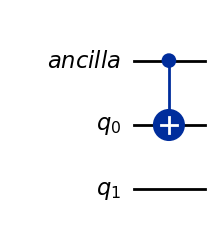

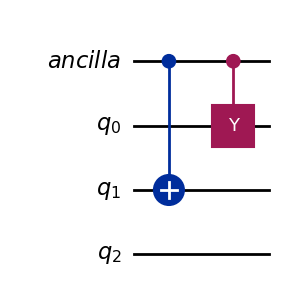

In [5]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Pauli, PauliList
from qiskit.exceptions import QiskitError

def CA(pauli_input, l=None):
    """
    Creates a controlled-Pauli circuit using an ancilla qubit as the control.
    
    Parameters:
        pauli_input (str, Pauli, PauliList or SparsePauliOp): 
            - A Pauli string (e.g., "IXY").
            - A Qiskit Pauli object (e.g., from SparsePauliOp.paulis[0]).
            - A Qiskit PauliList object, where the l-th Pauli will be used.
            - A Qiskit SparsePauliOp object, where the l-th Pauli will be used.
    
    The circuit uses two registers:
        - An ancilla register of size 1 named "ancilla" (the control qubit).
        - A data register of size nqubits named "q" (the target qubits).
    
    For each position in the Pauli operator:
        - 'I': Do nothing.
        - 'X': Apply a controlled-X (CX) gate.
        - 'Z': Apply a controlled-Z (CZ) gate.
        - 'Y': Apply a controlled-Y (CY) gate.
    
    Returns:
        QuantumCircuit: The constructed controlled-Pauli circuit.
    """
    
    # Convert input to a Pauli object if it is a string
    if isinstance(pauli_input, str):
        try:
            pauli = Pauli(pauli_input)  # Convert string to Pauli object
        except QiskitError:
            raise ValueError(f"Invalid Pauli string '{pauli_input}'. Allowed characters: I, X, Y, Z.")
    
    # If input is already a Pauli object, use it directly
    elif isinstance(pauli_input, Pauli):
        pauli = pauli_input
    
    # If input is PauliList or SparsePauliOp, extract the l-th pauli string
    elif isinstance(pauli_input, PauliList):
        try:
            pauli = pauli_input[l]  # Extract l-th pauli string
        except QiskitError:
            raise ValueError("The index, l, must be supplied if pauli_input contains more than one pauli string.")
        except IndexError:
            raise ValueError("The index, l, is out of bounds for the given PauliList.")
    
    elif isinstance(pauli_input, SparsePauliOp):
        try:
            pauli = pauli_input.paulis[l]  # Extract l-th pauli string
        except QiskitError:
            raise ValueError("The index, l, must be supplied if pauli_input contains more than one pauli string.")
        except IndexError:
            raise ValueError("The index, l, is out of bounds for the given PauliList.")
    
    # Reject invalid types
    else:
        raise TypeError(f"Expected input type str, Pauli, PauliList, or SparsePauliOp, but received {type(pauli_input)}.")
    
    # Determine the number of qubits
    nqubits = pauli.num_qubits
    
    # Create registers
    ancilla = QuantumRegister(1, name="ancilla")
    data = QuantumRegister(nqubits, name="q")
    
    # Create circuit
    circ = QuantumCircuit(ancilla, data, name="CA")
    
    # Loop over each Pauli term directly from the Pauli object
    for i, p in enumerate(pauli.to_label()):  # Ensure compatibility with string indexing. 
        # pauli.to_lable() converts Pauli Object to a string, e.g. "IXY"
        
        # Qiskit follows little Endian convention for qubit ordering. 
        # The most signifcant qubit is the one on the left in hand-written form. 
        # Hence, we need to reverse the index to match qubit numbering.
        i = nqubits - i - 1
        # E.g. nqubits =3, [0,1,2] becomes [2,1,0]
        
        if p == "I":
            continue
        elif p == "X":
            circ.cx(ancilla[0], data[i])
        elif p == "Z":
            circ.cz(ancilla[0], data[i])
        elif p == "Y":
            circ.cy(ancilla[0], data[i])
        else:
            raise ValueError(f"Unsupported Pauli operator: {p}")
    
    return circ
print(LCU.paulis[1])
display(CA(LCU.paulis[1]).draw("mpl"))
display(CA("IXY").draw("mpl"))

### Prepare $|b\rangle$ with $U |0\rangle$

For demonstration purposes, let's choose a $|b\rangle$ that is easy to prepare. Let
$$|b\rangle = \frac{1}{2} \begin{pmatrix} 1 \\ 1 \\ 1 \\ 1 \end{pmatrix}$$

$|b\rangle$ can be prepared by applying Hadamard gates to all qubits.

Given $A$ and $b$, we can easily obtain the solution x for final validation.

$$|x\rangle = \begin{pmatrix} 1 \\ 1.5 \\ 1.5 \\ 1 \end{pmatrix}$$

Let us define the circuit $U$. 

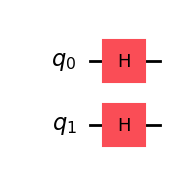

In [6]:
def U_hadamard(nqubits):
    """
    Creates a circuit of size 'nqubits' that prepares |b> as defined above.
    For our problem, we only need to apply Hadamard on each qubit to prepare |b>.
    
    In general, U_b would be a unitary that maps |0> to |b> (or vice versa).
    
    Returns:
        circuit (QuantumCircuit): A quantum circuit of size 'nqubits'.
    """
    circ = QuantumCircuit(nqubits, name="U_hadamard")
    # Example placeholder: apply H on each qubit
    for i in range(nqubits):
        circ.h(i)
    return circ

# |b> with two qubits:
display(U_hadamard(2).draw("mpl"))

### Fixed Structure Ansatz for $|x(\alpha)\rangle$
Consider the ansatz $V(\alpha)$, quantum a circuit that prepares a state $|x(\alpha)\rangle$ given a set of parameters, $\alpha$. 

There are different techniques for preparing the ansatz, including fixed ansatz, variable ansatz and Quantum Alternating Operator Ansatz (QAOA). 

Here, we use a very basic fixed ansatz.

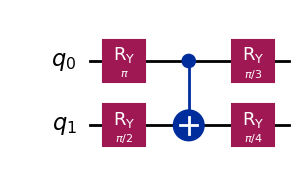

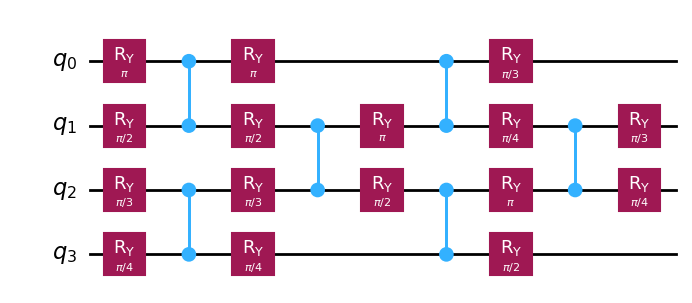

: 

In [ ]:

def apply_single_qubit_rotation(circuit, gate_type, angle, qubit_idx):
    gate_type = gate_type.strip().lower()
    if gate_type == "rx":
        circuit.rx(angle, qubit_idx)
    elif gate_type == "ry":
        circuit.ry(angle, qubit_idx)
    elif gate_type == "rz":
        circuit.rz(angle, qubit_idx)
    else:
        raise ValueError(f"Unsupported rotational gate: {gate_type}. Available gates are 'rx', 'ry', 'rz'.")

# Helper to apply two-qubit entangling gates
def apply_two_qubit_entangling(circuit, gate_type, ctrl, tgt):
    gate_type = gate_type.strip().lower()
    if gate_type == "cz":
        circuit.cz(ctrl, tgt)
    elif gate_type == "cx":
        circuit.cx(ctrl, tgt)
    elif gate_type == "cy":
        circuit.cy(ctrl, tgt)
    else:
        raise ValueError(f"Unsupported entangling gate: {gate_type}. Available gates are 'cz', 'cx', 'cy'.")

def fixed_ansatz(param, nqubits, rot_gates = "Ry", ent_gates = "CX"):
    """
    Creates a parameterized "ansatz circuit" on 'nqubits' data qubits.
    
    The circuit is built by first applying a layer of single-qubit rotation gates,
    followed by alternating layers of two-qubit entangling gates and additional
    single-qubit rotation layers. The entangling layers follow an alternating pattern:
    
    - Even-numbered layers (0, 2, ...): Apply entangling gates on qubit pairs (0,1), (2,3), ...
    - Odd-numbered layers (1, 3, ...):  Apply entangling gates on qubit pairs (1,2), (3,4), ...
    
    In non-final layers, the rotation gates are applied only to the qubits that will be entangled in the next layer.
    
    Input:
        param (list): A flat list of rotation angles. The list is partitioned into layers,
            with the first 'nqubits' elements used for the initial rotation layer.
        nqubits (int): The number of data qubits in the circuit.
        rot_gates (str, optional): The type of single-qubit rotation gate to apply 
            (e.g., "Rx", "Ry", or "Rz"). Default is "Ry".
        ent_gates (str, optional): The type of two-qubit entangling gate to apply 
            (e.g., "CX", "CZ", or "CY"). Default is "CX".
    
    Output:
    QuantumCircuit: The parameterized ansatz circuit.
    """
    
    # Initialize the ansatz circuit.
    ansatz = QuantumCircuit(nqubits, name="ansatz")
    
    layer_idx = 0
    
    # Populate the first layer of rotational gates
    for i in range(nqubits):
        try:
            apply_single_qubit_rotation(ansatz, rot_gates, param[i], i)
        except IndexError:
            raise IndexError("Index out of range for the first layer")
    param = param[nqubits:] # Remove the first layer from the parameters
    
    while True:
        # Even layer: entangle pairs (0,1), (2,3), ...
        if layer_idx % 2 == 0:
            if len(param) >= nqubits:
                for i in range(0, nqubits, 2):
                    apply_two_qubit_entangling(ansatz, ent_gates, i, i + 1)
                for i in range(0, nqubits):
                    apply_single_qubit_rotation(ansatz, rot_gates, param[i], i)
                param = param[nqubits:] # Remove this layer from the parameters
                layer_idx += 1
            else:
                return ansatz
        # Odd layer: entangle pairs (1,2), (3,4), ...
        elif layer_idx % 2 == 1:
            if len(param) >= max(nqubits - 2, 1):
                for i in range(1, nqubits - 1, 2):
                    apply_two_qubit_entangling(ansatz, ent_gates, i, i + 1)
                for param_idx, i in enumerate(range(1, nqubits - 1)):
                    apply_single_qubit_rotation(ansatz, rot_gates, param[param_idx], i)
                param = param[nqubits - 2:] # Remove this layer from the parameters
                layer_idx += 1
            else:
                return ansatz

param1 = [pi/1, pi/2, pi/3, pi/4]

param2 = [  pi/1, pi/2, pi/3, pi/4, 
            pi/1, pi/2, pi/3, pi/4, 
            pi/1, pi/2, 
            pi/3, pi/4, pi/1, pi/2, 
            pi/3, pi/4]

# Display the circuits with modified parameters
display(fixed_ansatz(param1, nqubits=2).draw("mpl"))
display(fixed_ansatz(param2, nqubits=4, ent_gates="cz").draw("mpl"))

The $Ry$ gates search the state space, while the $CX$ or $CZ$ gates create "interference" between qubits. Parameters are updated at each iteration.


Rz and CZ gates are native to IBM Heron processors.

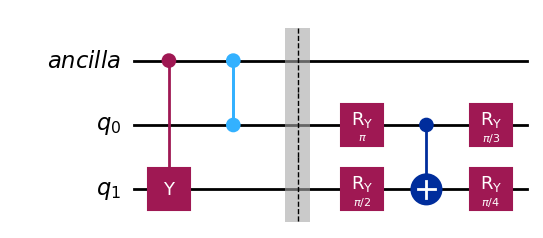

In [9]:
# Testing circuit composition

ancilla = QuantumRegister(1, name="ancilla")
data = QuantumRegister(2, name="q")
test_circ = QuantumCircuit(ancilla, data)

test_circ.compose(CA("YZ"), inplace=True)
test_circ.barrier()
test_circ.compose(fixed_ansatz(param=param1, nqubits=2), qubits=data[0:2], inplace=True)

display(test_circ.draw("mpl"))

### Hadamard Test for $C_L$

To calculate the local cost, we can use `Hadamard Test` circuit. The paper [5] introduces a new circuit, `Hadamard-Overlap Test`, to compute $C_L$. 

Recall the local cost, $C_L$:

$$ C_L = \frac{1}{2} - \frac{1}{2n} \frac{\sum_{j=1}^{n} \sum_{l=1}^{L} \sum_{l'=1}^{L} c_lc_{l'}^*\langle 0|V^\dagger A_{l'}^\dagger U Z_j U^\dagger A_l V|0 \rangle} {\sum_{l=1}^{L} \sum_{l'=1}^{L} c_lc_{l'}^* \langle 0|V^\dagger A_{l'}^\dagger A_l  V|0 \rangle}$$

A basic `Hadamard Test` looks like this, where $|\psi \rangle$ is the state of the data qubits and $|0\rangle$ is the ancilla qubit. 

This Hadamard test is designed to calculate $\langle \psi|U|\psi \rangle$. Let the probability of measuring $|0\rangle$ be $p_0$ and the probability of measuring $|1\rangle$ be $p_1$. According the theory on the Hadamard Test, the real part of $\langle \psi|U|\psi \rangle$ is $Re = p_0 - p_1$. 

To get the real (and imaginary) part, measuring the ancilla qubit is not the best method. Instead, we use one of the qiskit primitives, `EstimatorV2` (the other one is `SamplerV2`). 

Suppose the ancilla qubit is $|\psi\rangle$, then the expectation value is $\langle \psi | Z | \psi \rangle = p_0 - p_1 = Re$

Hence, in our case, we want to measure the expectation value of Pauli-Z on the ancilla qubit. 

The imaginary part can be calculated by adding a rotaional gate on the ancilla. 

![Hadamard test](images\Hadamard_test.webp)

Below is the Hadamard Test circuit: 

In our case, $|\psi\rangle$ is $V(w)|0\rangle$, $U$ is $A_l U Z_j U^\dagger A_{l'}^\dagger$

Notice that for Pauli matrices, $A_l = A_{l}^\dagger$. The order of $A_l$ and $A_{l'}^\dagger$ does not matter. 

In addition, $U$ and $U^\dagger$ are not controlled because they multiply to the identity matrix. Hence, if we control both of them, we are just controlling the identity matrix, which is equivalent to not controlling at all.

![Image from Pennylane](images\vqls_hadamard_test_circuit.png)

#### Constructing the Hadamard Test circuit

A_l is: IX
A_lp is: XX
j = 0

For the real part:


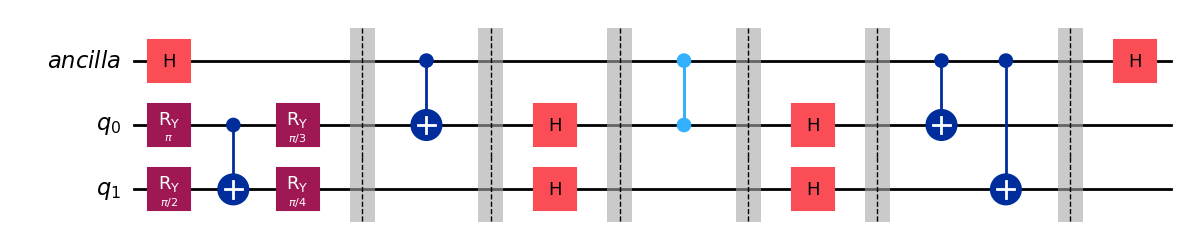

For the imaginary part:


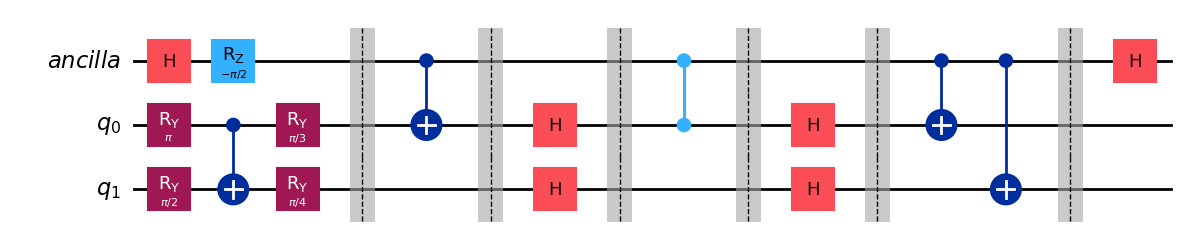

In [10]:

def local_hadamard_test(param, nqubits, l, j, lp, lcu = None, part="Re", rot_gates="Ry", ent_gates="CX"):
    """
    Builds the main circuit for the local Hadamard test as in your diagram.

    Args:
        param (list): Parameters for fixed_ansatz, e.g. [1, 2, 3, 3].
        nqubits (int): Number of data qubits (not counting the ancilla).
        l (int or Pauli_object): The l's pauli string in lcu (if lcu is provided), otherwise, Pauli_object for A_l (e.g. "IX").
        j (int): Index of the data qubit for the controlled-Z. If j = -1, skip the CZ.
        lp (int or Pauli_object): The l's pauli string in lcu (if lcu is provided), otherwise, Pauli_object for A_{l'} (e.g. "XX").
        nqubits (int): Number of data qubits (not counting the ancilla).

        part (str): "Re" or "Im". If "Im", apply a phase shift Rz(-pi/2) on the ancilla
                    to measure the imaginary part.
        lcu (PauliList or SparsePauliOp): PauliList or SparsePauliOp to use for l and lp. If lcu is None, then lp and l are 
        rot_gates (str): rotational gates for building the ansatz, "Ry" or "Rx" or "Rz".
        ent_gates (str): entangling gates for building the ansatz, "CX" or "CZ" or "CY".

    Returns:
        QuantumCircuit: The complete Hadamard test circuit with measurement on the ancilla.
    """
    # 0) If n_layers is not specified, determine it from the parameters and nqubits.
    
    # 0.5) If lcu is specified, use it to determine l and lp.
    if lcu is not None and isinstance(l,int) and isinstance(lp, int):
        # Check if l and lp are integers
        if not isinstance(l, int) or not isinstance(lp, int):
            raise TypeError("Indices l and lp must be integers.")
        
        # Check if l and lp are within the valid range
        if not (0 <= l < len(lcu)) or not (0 <= lp < len(lcu)):
            raise IndexError("Indices l and lp are out of range.")
        
        # Check if lcu is an instance of PauliList
        if isinstance(lcu, PauliList):
            pauli_l = lcu[l]
            pauli_lp = lcu[lp]
        # Check if lcu is an instance of SparsePauliOp
        elif isinstance(lcu, SparsePauliOp):
            pauli_l = lcu.paulis[l]
            pauli_lp = lcu.paulis[lp]
        else:
            raise TypeError("lcu must be an instance of PauliList or SparsePauliOp.")
    else:
        pauli_l = l
        pauli_lp = lp
    
    # 1) Create registers: 1 ancilla + nqubits data + 1 classical bit for measurement
    ancilla = QuantumRegister(1, name="ancilla")
    data = QuantumRegister(nqubits, name="q")
    # cbit = ClassicalRegister(1, name="c") # We are not taking measurements. 
    
    main_circuit = QuantumCircuit(ancilla, data, name="LocalHadamardTest")

    # 2) Hadamard on ancilla
    main_circuit.h(ancilla[0])

    # 2.5) (Optional) Phase shift for measuring imaginary part
    if part.lower().strip() in ["im", "imag", "imaginary"]:
        main_circuit.rz(-np.pi / 2, ancilla)

    # 3) Apply the fixed ansatz V(w) to the data qubits
    ansatz_circ = fixed_ansatz(param, nqubits, rot_gates, ent_gates)
    # Map data qubits of ansatz onto the 'data' register in main_circuit
    main_circuit.compose(ansatz_circ, qubits=data, inplace=True)
    main_circuit.barrier()
    
    # 4) Controlled A_l
    ca_l = CA(pauli_l)  # This subcircuit has 1 ancilla + nqubits data
    # Map the ancilla -> ancilla, data -> data[:]
    main_circuit.compose(
        ca_l,
        # qubits=[ancilla] + list(data),
        inplace=True
    )
    main_circuit.barrier()
    
    # 5) U_hadamard^\dagger
    ub_circ = U_hadamard(nqubits)
    main_circuit.compose(
        ub_circ.inverse(),
        qubits=data,  # apply to the data qubits
        inplace=True
    )
    main_circuit.barrier()
    
    # 6) Controlled-Z(ancilla, j) if j != -1
    if j != -1:
        main_circuit.cz(ancilla, data[j])
    main_circuit.barrier()
    
    # 7) U_hadamard
    main_circuit.compose(
        ub_circ,
        qubits=data,
        inplace=True
    )
    main_circuit.barrier()
    
    # 8) Controlled A_{l'}^\dagger
    # First build the subcircuit for A_{l'}, then invert it
    ca_lp = CA(pauli_lp)
    ca_lp_inv = ca_lp.inverse()
    main_circuit.compose(
        ca_lp_inv,
        qubits=[ancilla[0]] + list(data),
        inplace=True
    )
    main_circuit.barrier()
    
    # 9) Hadamard on ancilla
    main_circuit.h(ancilla)

    return main_circuit


print(f"A_l is: {LCU.paulis[1]}")
print(f"A_lp is: {LCU.paulis[2]}")
print("j = 0", end="\n\n")

print("For the real part:")
test_circ = local_hadamard_test(param1, nqubits=2, l=1, j=0, lp=2, lcu=LCU, part="Re")
display(test_circ.draw("mpl"))

print("For the imaginary part:")
test_circ2 = local_hadamard_test(param1, nqubits=2, l=1, j=0, lp=2, lcu=LCU, part="Im")
display(test_circ2.draw("mpl"))

## Evaluating the Quantum Circuit

### Aer Simulation

Here is a tutorial on [improving estimation of expectation values with Operator Backpropagation](https://learning.quantum.ibm.com/tutorial/improving-estimation-of-expectation-values-with-operator-backpropagation) from qiskit. 

#### Choosing a backend
For the backend, I will use `ibm_fez`, which is a Heron r2 machine. I do not have access to the real one. I will use `FakeFez()` to obtain a snapshot of the real machine.

If accessible, we can also choose a real device for backend, such as `ibm_brisbane`, though we need to connect to IBM Runtime Service. For instructions, search online or check out [Qiskit_Sample_Run](https://github.com/Weidsn/Quantum_Computing_Collaboration/blob/main/Qiskit/Qiskit_Sample_Run.ipynb) on Github. 

We only need calibration data from the quantum device for Aer Simulation. There is no rumtime cost from choosing so.


In [11]:
from qiskit_ibm_runtime.fake_provider import FakeFez

# For fake backend
backend = FakeFez()

# For real backend (ibm_brisbane)
# backend = QiskitRuntimeService().backend("ibm_brisbane")

# In general, to construct a AerSimulator from a backend
# simulator = AerSimulator().from_backend(backend)

simulator = AerSimulator()

#### Defining the observables

To calculate expectation values, we need to define the observables as qiskit `Pauli` objects, using `SparsePauliOp`. 

We are calculating the expectation value of $I \otimes I \otimes I \otimes \cdots \otimes Z$ with respect to the output of the Hadamard test. Hence, we need Pauli-Z operator on the ancilla qubit, and Identity operator on the data qubits. 

By the little Endian notation, the ancilla qubit is the least significant (LSB) so it comes last. 

In [12]:
nqubits = 2

# Use Pauli-Z on the ancilla qubit, I on other qubits.
observable = SparsePauliOp("I"* nqubits + "Z")

#### Optimizing the circuit

Using qiskit `transpiler` or `pass_manager` to optimize and transpile the circuit for the quantum backend. 

The backend we are using, ibm_fez, has 156 qubits and has limited connectivity between qubits. It also supports a limited number of quantum gates, e.g., Rz, X, CZ and sqrt(X) a.k.a. SX.


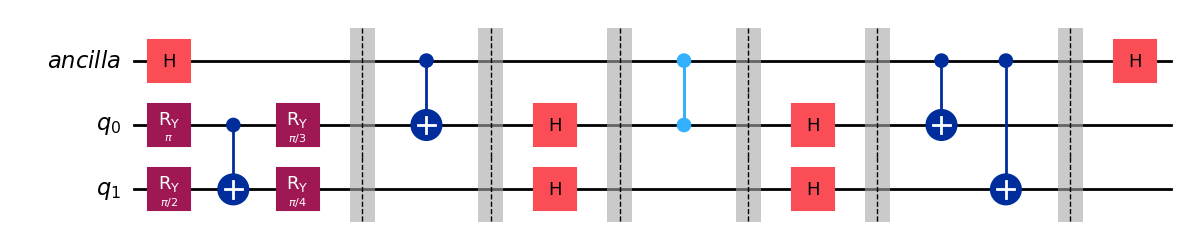

In [13]:
L = len(LCU.paulis)
n = nqubits
l = LCU.paulis[1]
lp = LCU.paulis[2] # from 1 to
j = 0 # from -1 to nqubits

qc = local_hadamard_test(param1, nqubits=2, l=l, j=j, lp=lp, part="Re")

qc_transpiled = transpile(circuits=qc, backend=simulator, optimization_level=1, layout_method="dense")
display(qc_transpiled.draw("mpl", idle_wires=False))

#### Removing barriers

We want to remove the barriers (gray dashed lines) from the circuit, which prevents full circuit optimization during transpilation, using `RemoveBarriers`. 

Here is a demostration. 

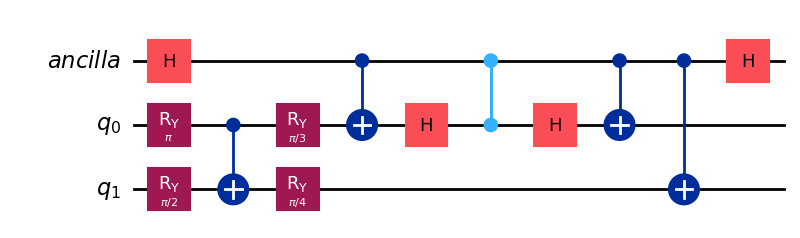

In [14]:
qc_nb = RemoveBarriers()(qc)
qc_transpiled_nb = transpile(qc_nb, backend=simulator, layout_method="dense", optimization_level=1)
display(qc_transpiled_nb.draw("mpl", idle_wires=False))

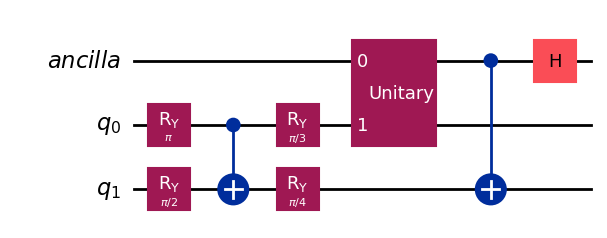

In [15]:
qc_nb = RemoveBarriers()(qc)
qc_transpiled_nb = transpile(qc_nb, backend=simulator, layout_method="dense", optimization_level=3)
display(qc_transpiled_nb.draw("mpl", idle_wires=False))

#### Transpiling the observables

We need to apply the layout of the transpiled circuit to the observables as well. The observables should be mapped to the corresponding physical qubits.

In [16]:
transpiled_obs = observable.apply_layout(qc_transpiled_nb.layout)

#### Building the Estimator

We import properties of the selected backend for Aer Simulation.

In [17]:
from qiskit_aer.primitives import EstimatorV2 as AerEstimatorV2

# We import properties of the selected backend for Aer Simulation. 
estimator = AerEstimatorV2().from_backend(simulator)
estimator.options.resilience_level = 2


In [18]:
job = estimator.run([(qc_transpiled_nb, transpiled_obs)])
result = job.result()

In [19]:
print(result)

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>)), metadata={'target_precision': 0.0, 'circuit_metadata': {}, 'simulator_metadata': {'omp_enabled': True, 'parallel_experiments': 1, 'max_memory_mb': 40132, 'max_gpu_memory_mb': 0, 'time_taken_execute': 0.0004354, 'time_taken_parameter_binding': 2.49e-05}})], metadata={'version': 2})


#### Extracting the result

In [20]:
exp_value_list = result[0].data.evs
print(exp_value_list)

-0.6123724356957949


#### Generating the pipline

The `eval_circ()` function transpiles and evaluates a circuit using Aer EstimatorV2. It returns the expectation value of Pauli-Z on the ancilla qubit.

In [22]:

def eval_circ(circ, backend, opt_lv=3, res_lv=2):
    """This circuit evaluates circ using Aer EstimatorV2 with observable Z for LSB and I for every other qubit.
    It is intended to be used on Hadamard test circuits, where LSB is the ancilla.
    In that case, it evaluates the expecation value of Pauli-Z for the ancilla.  
    
    Estimator Options:
    resilience level = res_lv
    
    Transpiler Options:
    optimization_level = opt_lv
    layout_method = "dense"
    
    Args:
        circ (QuantumCircuit): The Hadamard test circuit.
        backend (Backend): Backend to run the circuit on.
        opt_lv (int, optional): Transpiler optimization level (1 to 3). Defaults to 3.
        res_lv (int, optional): Estimator resilience level (0 to 2), which controls error mitigation. Defaults to 2.
        
    Returns:
        float: Expectation value of Pauli-Z on the ancilla (LSB).
    """
    
    nqubits = circ.num_qubits - 1
    # Remove barriers
    circ = RemoveBarriers()(circ)
    
    # Construct the observables
    obs = SparsePauliOp("I"* nqubits + "Z")
    
    # Transpile the circuit and observables
    circ_transpiled = transpile(circ, backend=backend, layout_method="dense", optimization_level=opt_lv)
    transpiled_obs = obs.apply_layout(circ_transpiled.layout)
    
    # Building the Estimator using Aer Simulation with backend as the backend. 
    estimator = AerEstimatorV2().from_backend(backend)
    estimator.options.resilience_level = res_lv
    
    result = estimator.run([(circ_transpiled, transpiled_obs)]).result()
    exp_value = result[0].data.evs
    return exp_value.item()
    

#### Testing eval_circ() function. 

> Negative values are to be expected since we are not calculating the local cost yet, just a single expectation value term.

In [ ]:
# Testing eval_circ

# Building two Hadamard Test circuits with or without the imaginary part.
qc = local_hadamard_test(param1, nqubits=2, l=1, j=0, lp=2, lcu = LCU, part="re")
qc_im = local_hadamard_test(param1, nqubits=2, l=1, j=0, lp=2, lcu = LCU, part="im")

# Ideal backend, real part
result_eval_circ_ideal = eval_circ(qc, backend=simulator)
print(type(result_eval_circ_ideal))
print(result_eval_circ_ideal)

<class 'float'>
-0.6123724356957949


In [41]:
# FakeFez backend, real part
result_eval_circ = eval_circ(qc, backend=FakeFez(), opt_lv=3, res_lv=2)
print(result_eval_circ)

-0.5973018531064792


In [44]:
# FakeFex backend, combining the imaginary part
result_eval_circ2 = eval_circ(qc_im, backend=FakeFez(), opt_lv=3, res_lv=2)
print(result_eval_circ2)

0.0003981960548581076


#### Defining local cost function

The `local_cost()` function combines every quantum step. It evaluates the local cost, given a set of parameters, $\alpha$.

In [23]:
def local_cost(param, nqubits, lcu, backend, Im_part=False, opt_lv=3, res_lv=2): 
    """This function evaluates the Hadamard test for a given parameter and LCU.

    Args:
        param: float
            The parameter for the Hadamard test
        lcu: PauliList or SparsePauliOp object
            The Pauli decomposition of the matrix A. 

    Returns:
        exp_value_list: list
    """
    L = len(lcu.paulis)
    nqubits = lcu.num_qubits
    
    # Evaluate the denominator
    Denominator = 0
    # For the real part
    for l in range(L):
        for lp in range(L):
            circ = local_hadamard_test(param, nqubits, l, -1, lp, part = "Re", lcu=lcu)
            # Multiplying coefficients with the expectation value.
            Denominator += (lcu.coeffs[l] * np.conjugate(lcu.coeffs[lp]) * 
                            eval_circ(circ, backend=backend, opt_lv=opt_lv, res_lv=res_lv))
    # Imaginary part
    if Im_part:
        for l in range(L):
            for lp in range(L):
                circ = local_hadamard_test(param, nqubits, l, -1, lp, part = "Im", lcu=lcu)
                # Multiplying coefficients with the expectation value.
                Denominator += (lcu.coeffs[l] * np.conjugate(lcu.coeffs[lp]) * 
                                   eval_circ(circ, backend=backend, opt_lv=opt_lv, res_lv=res_lv)) * 1.0j
    
    # Evaluate the Numerator
    Numerator = 0
    for l in range(L):
        for lp in range(L):
            for j in range(nqubits): # j is from 0 to nqubits-1
                circ = local_hadamard_test(param, nqubits, l, j, lp, part = "Re", lcu=lcu)
                # Multiplying coefficients with the expectation value.
                Numerator += (lcu.coeffs[l] * np.conjugate(lcu.coeffs[lp]) * 
                                eval_circ(circ, backend, opt_lv, res_lv))
    # Imaginary part
    if Im_part:
        for l in range(L):
            for lp in range(L):
                for j in range(nqubits):
                    circ = local_hadamard_test(param, nqubits, l, j, lp, part = "Im", lcu=lcu)
                    # Multiplying coefficients with the expectation value.
                    Numerator += (lcu.coeffs[l] * np.conjugate(lcu.coeffs[lp]) * 
                                    eval_circ(circ, backend, opt_lv, res_lv)) * 1.0j
    
    # The final result
    local_cost = 1/2 - ( 1/(2*nqubits) * (Numerator / Denominator))
    return abs(local_cost)

In [ ]:
# Testing local_cost() function

param3 = [pi/6, pi/2, pi/2, pi/6]

# Ideal simulator, real part only.
result_local_cost = local_cost(param3, nqubits = 2, lcu = LCU, backend=simulator, Im_part=True)
print("Ideal simulation result:")
print(result_local_cost)

Ideal simulation result:
0.5594881973370138


In [ ]:
# FakeFez, with imaginary part. 
result_local_cost2 = local_cost(param3, nqubits=2, lcu=LCU, backend=FakeFez(), Im_part=True)
print(result_local_cost2)

0.5555210846218074


In [35]:
# FakeFez, real part only.
result_local_cost3 = local_cost(param3, nqubits=2, lcu=LCU, backend=FakeFez(), Im_part=False)
print(result_local_cost3)

0.5531358364262174


### Classical Optimization

We use scipy's `minimize` function to find the optimal parameters.

We define a CostTracker object to track the local cost at each iteration. 

In [55]:
from scipy.optimize import minimize

class CostTracker:
    # Initializes the CostTracker object.
    # We initialize with a cost function, e.g., local_cost(),
    # combined with all necessary configuration of the cost function, except param. 
    def __init__(self, cost_fn, *args, **kwargs):
        self.cost_fn = cost_fn
        # Positional arguments to be passed to cost_fn (e.g., nqubits, lcu, backend).
        self.args = args
        # Keyword arguments to be passed to cost_fn (e.g., Im_part=True, opt_lv=2).
        self.kwargs = kwargs
        self.latest_cost = None

    # Allows the CostTracker object to be called like a function.
    # It takes only one argument (representing the ansatz parameters), as required by minimize().
    # Return the cost value.  
    def __call__(self, param):
        # Evaluate the cost function with the given parameters and args/kwargs stored when initializing the object. 
        cost = self.cost_fn(param, *self.args, **self.kwargs)
        self.latest_cost = cost
        return cost

    def callback(self, xk):
        print(f"Step: params = {xk}, cost = {self.latest_cost}")

In [ ]:
# Testing optimization loop with 2 iterations. 
# Initializing CostTracker object.
tracked_cost = CostTracker(local_cost, nqubits=2, lcu=LCU, backend=simulator)

Defining a callback function to print the progress of the optimization.

In [73]:
# Optimization run

# Initial condition
param3 = [pi/6, pi/2, pi/2, pi/6]

result2 = minimize(tracked_cost, x0=param3, method="COBYLA", options={'maxiter': 400}, callback=tracked_cost.callback)
print(result2)
x_2 = result2.x

Step: params = [1.52359878 1.57079633 1.57079633 0.52359878], cost = 0.5594881973370138
Step: params = [1.52359878 2.57079633 1.57079633 0.52359878], cost = 0.5377362521169787
Step: params = [1.52359878 2.57079633 2.57079633 0.52359878], cost = 0.4987675781085687
Step: params = [1.52359878 2.57079633 1.57079633 1.52359878], cost = 0.505559892975801
Step: params = [ 1.92740018  3.29420774  1.44470433 -0.02203953], cost = 0.528159983373574
Step: params = [1.02498896 2.60025898 1.56566093 0.50137635], cost = 0.719983853418278
Step: params = [0.92814064 2.78250906 1.53389439 0.36391291], cost = 0.4866061490545586
Step: params = [1.02498896 2.52498735 1.56566093 0.40158065], cost = 0.4944165905671424
Step: params = [0.90768225 2.31077408 1.53699529 0.44663717], cost = 0.4838509602658574
Step: params = [1.05234346 2.17629005 1.3841967  0.4348148 ], cost = 0.48002728409454526
Step: params = [1.14703341 2.00182781 1.53481396 0.41453721], cost = 0.47741202146270934
Step: params = [0.92127203 2.

### Verifying the output

In [74]:
# The optimized parameters obtained from the optimization loop are inserted directly.
output_parameter = result2.x

# Normally, we extract the result directly from minimize().
# output_parameter = result2.x

print("The output parameters are:", output_parameter)

The output parameters are: [ 0.72642135  2.18837651  0.94381833 -0.48800867]


### Post Processing

Extract final output and compare it with the real solution. 

First, we need to extract the final ouput from the anzatz circuit using output parameters. We can perform the quantum state readout classically so long as the ansatz circuit can be efficiently simulated. 

We use Aer Simulater to classically extract the hidden quantum state, which will be our normalized vector, $|x\rangle$. 

In [ ]:
# Defining a function that return the ideal statevector obtained from the ansatz using parameters as input. 
# We use Aer Simulator for this procedure. 
def evaluate_ansatz(param, rot_gates="Ry", ent_gates = "CX"):
    """Using Aer Simulater, evaluate the ansatz circuit and return the statevector before readout.

    Args:
        param (array): Parameters for the ansatz.
        rot_gates (str, optional): Rotational gates used by the ansatz generator. Defaults to "Ry".
        ent_gates (str, optional): Entangling gates used by the ansatz generator. Defaults to "CX".

    Returns:
        Statevector: The ideal quantum statevector before state readout. 
    """
    circ = fixed_ansatz(param, nqubits=nqubits, rot_gates=rot_gates, ent_gates=ent_gates)
    circ.save_statevector() # To tell Aer simulator to save the statevector.
    
    simulator = AerSimulator()  # Set up the simulator
    
    circ = transpile(circ, simulator) # transpile the circuit
    
    result = simulator.run(circ).result() # Obtain the result
    
    statevector = result.get_statevector() # Get the statevector
    
    return statevector

In [84]:
statevector = evaluate_ansatz(output_parameter, rot_gates="Ry", ent_gates = "CX")

print("Solution vector:")
display(array_to_latex(statevector))

Solution vector:


<IPython.core.display.Latex object>

In [106]:
# Testing our solution against b. 
solution_b = np.matmul(A, np.array(statevector))

print("Ax vector:")
display(array_to_latex(solution_b))

# Defining b vector.
ketb = np.array((1/np.sqrt(4)) * np.array([1, 1, 1, 1]))

print("Normalized b vector:")
display(array_to_latex(ketb))

Ax vector:


<IPython.core.display.Latex object>

Normalized b vector:


<IPython.core.display.Latex object>

Looks like we are on the right track. Our Ax is proportional to the real b. 

#### Denormalizing solution vector, x

To determine the normalization factor, I choose to minimize the squared error.

In [138]:
# Denormalizing solution x

# Least squared method: minimize the squared error
k_ls = np.vdot(ketb, ketb) / np.vdot(solution_b, ketb)

x_ls = k_ls * statevector

print("Denormalized solution vector (least squared method):")
display(array_to_latex(x_ls))

# Actual solution x
x_actual = np.array([1, 1.5, 1.5, 1])
print("Actual solution:")
display(array_to_latex(x_actual, precision=10))

# Calculating squared error
error = x_ls - x_actual
squared_error = np.vdot(error, error).real
print(f"Squared error: {squared_error}")

Denormalized solution vector (least squared method):


<IPython.core.display.Latex object>

Actual solution:


<IPython.core.display.Latex object>

Squared error: 1.676345996404616e-08


## Acknowledgements

This implementation is based on the work presented in the research paper [5] by Carlos Bravo-Prieto, Ryan LaRose, M. Cerezo, Yiğit Subaşı, Lukasz Cincio, and Patrick J. Coles.